In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import random
import seaborn as sns

from collections import Counter

In [689]:
def pre_processamento():
    #xlsx = pd.ExcelFile('casos_corona.xlsx')
    #df = pd.read_excel(xlsx, 'casos_corona')
    xlsx = pd.ExcelFile('coronga_atualizado.xlsx')
    df = pd.read_excel(xlsx, 'casos_coronavirus')
    df = df[:10000] ################################limitando o dataset
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente', 'idadePaciente']]
    
    novo_df = []
    for i in range(len(df)):
        if(df.loc[i][2] == 'Positivo'):
            resultado = 1
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
        else:
            resultado = 0
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
    
    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente', 4: 'idade_paciente'}, inplace=True)    
    return novo_df

In [690]:
df = pre_processamento()
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente,idade_paciente
0,MONSENHOR SABINO,ACARAU,1,FEMININO,62
1,LAGOA DO MATO,ITATIRA,1,MASCULINO,18
2,CROATA II,PACAJUS,1,FEMININO,24
3,ZONA RURAL,NOVO ORIENTE,0,FEMININO,30
4,CENTRO,TIANGUA,0,MASCULINO,47
...,...,...,...,...,...
9995,CENTRO,ITAPAJE,1,FEMININO,76
9996,PIRATININGA,MARACANAU,1,FEMININO,41
9997,CHACARA DA PRAINHA,AQUIRAZ,1,MASCULINO,56
9998,MESSEJANA,FORTALEZA,1,MASCULINO,31


In [691]:
def agrupar_idade(df):
    clusters_idades = []
    idade_max = max(df['idade_paciente'])
    
    for x in range(0,5):
        if((idade_max+x)%5 == 0):
            dif = x
            
    intervalos = np.arange(0, idade_max+dif, dtype=int)
            
    for i in range(0, int(idade_max+dif), 5):
        gaps = []
        for j in range(i, i+5):
            gaps.append(intervalos[j])
        clusters_idades.append(gaps)

    casos_idade = []

    for cluster in clusters_idades:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][4] in cluster and df.loc[i][2] == 1):
                count = count + 1
        casos_idade.append(['[{}:{}]'.format(cluster[0], cluster[4]), count])
    casos_idade = pd.DataFrame(casos_idade)
    casos_idade.rename(columns={0: 'idade', 1: 'count'}, inplace=True)
    casos_idade = casos_idade.sort_values(by=['count'], ascending=True)
    ordem = np.arange(1,len(casos_idade)+1)
    casos_idade['ordem'] = pd.Series(ordem, index=casos_idade.index)
    return casos_idade

In [692]:
dataset_idade = agrupar_idade(df)
dataset_idade

,idade,count,ordem
23,[115:119],0,1
21,[105:109],0,2
22,[110:114],0,3
20,[100:104],1,4
19,[95:99],12,5
18,[90:94],26,6
1,[5:9],62,7
17,[85:89],65,8
2,[10:14],77,9
16,[80:84],96,10


In [693]:
def top_k_reverse_idade(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmin()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'idade', 1: 'count'})
    return output

In [725]:
top_k_reverse_idade(dataset_idade, 10)

,idade,count
0,[115:119],0
1,[105:109],0
2,[110:114],0
3,[100:104],1
4,[95:99],12
5,[90:94],26
6,[5:9],62
7,[85:89],65
8,[10:14],77
9,[80:84],96


# Ruído de Laplace

In [695]:
def sensibilidade_lap(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

In [696]:
def plot_erros(erros_argumento, k, metodo):
    df = pd.DataFrame({
        'epsilon': ['0.1', '1', '3', '5', '8', '10'],
        'F1 Score': erros_argumento })
    sns.catplot(x="epsilon", y="F1 Score", palette="ch:.5",
                data=df, saturation=.7,
                kind="bar", ci=None, aspect=.9, order=['0.1', '1', '3', '5', '8', '10'])

    plt.title("Média utilizando a métrica F1 Score para {}".format(metodo))
    plt.xlabel("Epsilon")
    plt.ylabel("F1 Score, k = {}".format(k))
    return plt.show()

In [697]:
#def f1_score(query, argumento_consulta, budgets):
#    top = list(query) 
#    metrica_exponencial = []
#    for argumento, budget in zip(argumento_consulta, budgets):
#        falsos_positivos, falsos_negativos, verdadeiros_positivos = 0, 0, 0
#        for i in range(len(argumento)):
#            if(argumento[i] in top):                  #if(argumento[i][0] in top[:][0]):
#                if(argumento[i] == top[i]):                #if(argumento[i][0] == top[i][0] or argumento[i][1] == top[i][1]):
#                    verdadeiros_positivos += 1
#                else:
#                    falsos_positivos += 1
#            if(top[i] not in argumento):              #if(top[i][0] not in argumento[:][0]):
#                falsos_negativos += 1
#            if(argumento[i] not in top):              #if(argumento[i][0] not in top[:][0]):
#                falsos_positivos += 1
#
#        print("epsilon = {}:\nVerdadeiros Positivos: {}\nFalsos Positivos: {}\nFalsos Negativos: {}\n\n".format(budget, verdadeiros_positivos, falsos_positivos, falsos_negativos))
#
#        precisao = verdadeiros_positivos/(verdadeiros_positivos + falsos_positivos) 
#        revocacao = verdadeiros_positivos/(verdadeiros_positivos + falsos_negativos)
#
#        f1_score = 2*((revocacao * precisao)/(revocacao + precisao))
#        metrica_exponencial.append(f1_score)
#    
#    print(metrica_exponencial)
#
#    return metrica_exponencial

In [790]:
#modificado
def f1_score(query, argumento_consulta, budgets):
    top_classes = list(query['idade'])
    top_count = list(query['count'])
    
    metrica_exponencial = []
    for argumento, budget in zip(argumento_consulta, budgets):
        falsos_positivos, falsos_negativos, verdadeiros_positivos = 0, 0, 0
        for i in range(len(argumento)):
            if(argumento[i] in top_classes):                 
                if(argumento[i] == top_classes[i] or (argumento[i] in [query['idade'][x] for x in range(len(query['idade'])) if(top_count.count(query['count'][x]) > 1)])):  #(top_count.count(top_count[i]) > 1)):
                    verdadeiros_positivos += 1
                    #print(argumento[i] in [query['idade'][x] for x in range(len(query['idade'])) if(top_count.count(query['count'][x]) > 1)])
                else:
                    falsos_positivos += 1
            if(top_classes[i] not in argumento):
                falsos_negativos += 1
            if(argumento[i] not in top_classes):
                falsos_positivos += 1

        print("epsilon = {}:\nVerdadeiros Positivos: {}\nFalsos Positivos: {}\nFalsos Negativos: {}\n\n".format(budget, verdadeiros_positivos, falsos_positivos, falsos_negativos))

        precisao = verdadeiros_positivos/(verdadeiros_positivos + falsos_positivos) 
        revocacao = verdadeiros_positivos/(verdadeiros_positivos + falsos_negativos)

        f1_score = 2*((revocacao * precisao)/(revocacao + precisao))
        metrica_exponencial.append(f1_score)
    
    print(metrica_exponencial)

    return metrica_exponencial

# Consulta Idade com ruído

In [699]:
def laplace_idade(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_idades = np.array(query['idade'])
    output = []
    #np.random.seed(7)
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    output = {
        'idade': coluna_idades,
        'count': output
    }
    
    df = pd.DataFrame(output, columns = ['idade', 'count'])
    return df.sort_values(by=['count'],ascending=True)

In [853]:
budgets = [0.1, 1, 3, 5, 8, 10]
idades = []
k = 10
for budget in budgets:
    a = laplace_idade(budget, sensibilidade_lap(dataset_idade, budget, 10), top_k_reverse_idade(dataset_idade, 10), dataset_idade, 10)
    a = np.array(a)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, a))
    idades.append(a[:,0])

epsilon: 0.1
reverse top-k:
[['[115:119]' -17.390225911581194]
 ['[110:114]' -14.295223792657358]
 ['[100:104]' -6.648070646458551]
 ['[95:99]' 11.58948350159113]
 ['[105:109]' 16.32493596980283]
 ['[90:94]' 34.12171456531709]
 ['[85:89]' 55.25384857144388]
 ['[10:14]' 69.41797771475586]
 ['[5:9]' 92.72030208325467]
 ['[80:84]' 144.15965777963692]]


epsilon: 1
reverse top-k:
[['[110:114]' -0.28346843820229184]
 ['[115:119]' 0.12141933315933157]
 ['[100:104]' 0.507104129189826]
 ['[105:109]' 1.1629935862686713]
 ['[95:99]' 13.254489897439946]
 ['[90:94]' 25.200620979831864]
 ['[5:9]' 61.42684381852585]
 ['[85:89]' 64.72370181242167]
 ['[10:14]' 76.63776537377646]
 ['[80:84]' 95.00500094493229]]


epsilon: 3
reverse top-k:
[['[105:109]' -0.2616278038161068]
 ['[115:119]' -0.1347449858036239]
 ['[110:114]' 0.01667490940023954]
 ['[100:104]' 1.1217112864026029]
 ['[95:99]' 12.007887018356206]
 ['[90:94]' 25.51682812000969]
 ['[5:9]' 62.04920388901413]
 ['[85:89]' 65.13700236800325]
 ['[10

epsilon = 0.1:
Verdadeiros Positivos: 5
Falsos Positivos: 5
Falsos Negativos: 0


epsilon = 1:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.6666666666666666, 0.9473684210526316, 1.0, 1.0, 1.0, 1.0]


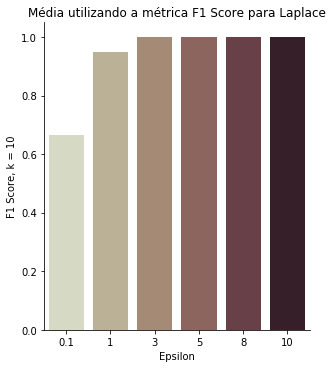

In [854]:
query_idades = top_k_reverse_idade(dataset_idade, 10)
metodo = 'Laplace'
f1_lap = f1_score(query_idades, idades, budgets)
plot_erros(f1_lap, 10, metodo)

# Mecanismo Exponencial

In [793]:
def score_function_exp(dataset):
    return -dataset['count']

In [794]:
def sensibilidade_exp(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

# Consulta Idade Exponencial

In [795]:
def exp_idades(budget, sensibilidade, dataset, k):
    budget = budget/k

    scores = score_function_exp(dataset)

    _users = list(dataset['idade'].copy())
    _scores = list(scores.copy())
    counts = list(dataset['count'].copy())

    top = []

    for i_run in range(k):

        probabilities = []

        for j_score in _scores:
            probability = math.exp( (budget * j_score) / (2 * sensibilidade) )
            probabilities.append(probability)

        probabilities = [j_probability/sum(probabilities) for j_probability in probabilities]

        sample = random.choices(population=_users, weights=probabilities, k=1)[0]
        
        count = counts[_users.index(sample)]

        top.append([sample, count])

        _scores.remove(_scores[_users.index(sample)])
        _users.remove(sample)
        counts.remove(count)

    return top

In [846]:
idades_exp = []

for budget in budgets:
    b = exp_idades(budget, sensibilidade_exp(dataset_idade, budget, 10), dataset_idade, 10)
    b = np.array(b)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, b))
    idades_exp.append(b[:,0])

epsilon: 0.1
reverse top-k:
[['[5:9]' '62']
 ['[110:114]' '0']
 ['[95:99]' '12']
 ['[100:104]' '1']
 ['[10:14]' '77']
 ['[0:4]' '96']
 ['[55:59]' '341']
 ['[70:74]' '195']
 ['[60:64]' '284']
 ['[115:119]' '0']]


epsilon: 1
reverse top-k:
[['[90:94]' '26']
 ['[100:104]' '1']
 ['[105:109]' '0']
 ['[110:114]' '0']
 ['[95:99]' '12']
 ['[85:89]' '65']
 ['[115:119]' '0']
 ['[0:4]' '96']
 ['[5:9]' '62']
 ['[15:19]' '139']]


epsilon: 3
reverse top-k:
[['[105:109]' '0']
 ['[115:119]' '0']
 ['[100:104]' '1']
 ['[110:114]' '0']
 ['[95:99]' '12']
 ['[90:94]' '26']
 ['[5:9]' '62']
 ['[85:89]' '65']
 ['[10:14]' '77']
 ['[80:84]' '96']]


epsilon: 5
reverse top-k:
[['[100:104]' '1']
 ['[105:109]' '0']
 ['[115:119]' '0']
 ['[110:114]' '0']
 ['[95:99]' '12']
 ['[90:94]' '26']
 ['[5:9]' '62']
 ['[85:89]' '65']
 ['[10:14]' '77']
 ['[80:84]' '96']]


epsilon: 8
reverse top-k:
[['[115:119]' '0']
 ['[105:109]' '0']
 ['[110:114]' '0']
 ['[100:104]' '1']
 ['[95:99]' '12']
 ['[90:94]' '26']
 ['[5:9]' '62']
 

In [847]:
idades_exp

[array(['[5:9]', '[110:114]', '[95:99]', '[100:104]', '[10:14]', '[0:4]',
        '[55:59]', '[70:74]', '[60:64]', '[115:119]'], dtype='<U9'),
 array(['[90:94]', '[100:104]', '[105:109]', '[110:114]', '[95:99]',
        '[85:89]', '[115:119]', '[0:4]', '[5:9]', '[15:19]'], dtype='<U9'),
 array(['[105:109]', '[115:119]', '[100:104]', '[110:114]', '[95:99]',
        '[90:94]', '[5:9]', '[85:89]', '[10:14]', '[80:84]'], dtype='<U9'),
 array(['[100:104]', '[105:109]', '[115:119]', '[110:114]', '[95:99]',
        '[90:94]', '[5:9]', '[85:89]', '[10:14]', '[80:84]'], dtype='<U9'),
 array(['[115:119]', '[105:109]', '[110:114]', '[100:104]', '[95:99]',
        '[90:94]', '[5:9]', '[85:89]', '[10:14]', '[80:84]'], dtype='<U9'),
 array(['[105:109]', '[115:119]', '[110:114]', '[100:104]', '[95:99]',
        '[90:94]', '[5:9]', '[85:89]', '[10:14]', '[80:84]'], dtype='<U9')]

epsilon = 0.1:
Verdadeiros Positivos: 3
Falsos Positivos: 7
Falsos Negativos: 4


epsilon = 1:
Verdadeiros Positivos: 4
Falsos Positivos: 6
Falsos Negativos: 2


epsilon = 3:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.3529411764705882, 0.5, 0.9473684210526316, 0.9473684210526316, 1.0, 1.0]


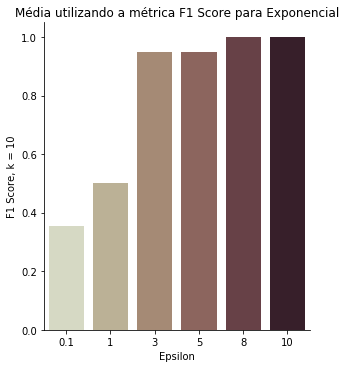

In [848]:
metodo = 'Exponencial'
f1 = f1_score(query_idades, idades_exp, budgets)
plot_erros(f1, 10, metodo)

# Calculando a média dos valores para cada epsilon
## Pros resultados não serem aleatórios

### Laplace

In [800]:
aux_lap = []
query_idades = top_k_reverse_idade(dataset_idade, 10)
for i in range(10):
    lista_lap = []
    for eps in budgets:
        res = np.array(laplace_idade(eps, sensibilidade_lap(dataset_idade, eps, 10), top_k_reverse_idade(dataset_idade, 10), dataset_idade, 10))
        lista_lap.append(res[:, 0])
    f1_lap = f1_score(query_idades, lista_lap, budgets)
    aux_lap.append(f1_lap)
aux_lap

epsilon = 0.1:
Verdadeiros Positivos: 7
Falsos Positivos: 3
Falsos Negativos: 0


epsilon = 1:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.8235294117647058, 0.9473684210526316, 1.0, 1.0, 1.0, 1.0]
epsilon = 0.1:
Verdadeiros Positivos: 7
Falsos Positivos: 3
Falsos Negativos: 0


epsilon = 1:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos

[[0.8235294117647058, 0.9473684210526316, 1.0, 1.0, 1.0, 1.0],
 [0.8235294117647058, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.8235294117647058, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.5714285714285715, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.8235294117647058, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.8235294117647058, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0]]

In [801]:
lista_de_listas = []
for i in range(len(aux_lap[0])):
    listinha = []
    for j in range(len(aux_lap)):
        listinha.append(aux_lap[j][i])
    lista_de_listas.append(listinha)
medias_lap = [0]*len(lista_de_listas)
for i in range(len(lista_de_listas)):
    medias_lap[i] = np.mean(lista_de_listas[i])
medias_lap

[0.7522408963585434, 0.9947368421052631, 1.0, 1.0, 1.0, 1.0]

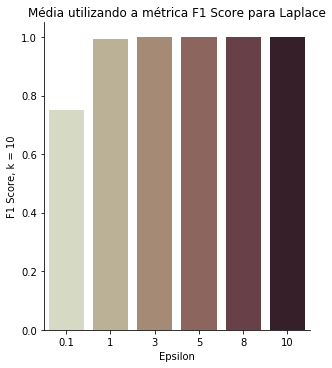

In [802]:
metodo = 'Laplace'
plot_erros(medias_lap, 10, metodo)

### Exponencial

In [834]:
aux = []
for i in range(10):
    lista = []
    for eps in budgets:
        hm = np.array(exp_idades(eps, sensibilidade_exp(dataset_idade, eps, 10), dataset_idade, 10))
        lista.append(hm[:,0])
    f1 = f1_score(query_idades, lista, budgets)
    aux.append(f1)
aux

epsilon = 0.1:
Verdadeiros Positivos: 3
Falsos Positivos: 7
Falsos Negativos: 4


epsilon = 1:
Verdadeiros Positivos: 6
Falsos Positivos: 4
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 7
Falsos Positivos: 3
Falsos Negativos: 1


epsilon = 5:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 0


[0.3529411764705882, 0.7499999999999999, 0.7777777777777777, 0.9473684210526316, 0.9473684210526316, 0.9473684210526316]
epsilon = 0.1:
Verdadeiros Positivos: 3
Falsos Positivos: 7
Falsos Negativos: 2


epsilon = 1:
Verdadeiros Positivos: 5
Falsos Positivos: 5
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 1


epsilon = 5:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 1


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativo

[[0.3529411764705882,
  0.7499999999999999,
  0.7777777777777777,
  0.9473684210526316,
  0.9473684210526316,
  0.9473684210526316],
 [0.4, 0.6666666666666666, 0.8421052631578948, 0.8421052631578948, 1.0, 1.0],
 [0.3529411764705882,
  0.625,
  0.9,
  0.888888888888889,
  0.8421052631578948,
  0.8421052631578948],
 [0.4, 0.4615384615384615, 0.9473684210526316, 1.0, 0.9, 1.0],
 [0.125, 0.5714285714285715, 0.625, 0.7777777777777777, 0.9, 0.9],
 [0.37499999999999994,
  0.7058823529411764,
  0.7058823529411764,
  0.9473684210526316,
  0.8421052631578948,
  0.9473684210526316],
 [0.14285714285714288,
  0.7777777777777777,
  0.9473684210526316,
  0.7499999999999999,
  0.9473684210526316,
  0.9],
 [0.5,
  0.4285714285714285,
  0.7058823529411764,
  0.8421052631578948,
  0.8421052631578948,
  0.9473684210526316],
 [0.25, 0.5333333333333333, 0.7777777777777777, 0.7777777777777777, 1.0, 1.0],
 [0.26666666666666666,
  0.7499999999999999,
  0.625,
  0.9,
  0.9473684210526316,
  1.0]]

In [835]:
que = []
for i in range(len(aux[0])):
    mano = []
    for j in range(len(aux)):
        mano.append(aux[j][i])
    que.append(mano)
medias = [0]*len(que)
for i in range(len(que)):
    medias[i] = np.mean(que[i])
medias

[0.3165406162464986,
 0.6270198592257415,
 0.7854162366701065,
 0.8673391812865496,
 0.9168421052631579,
 0.948421052631579]

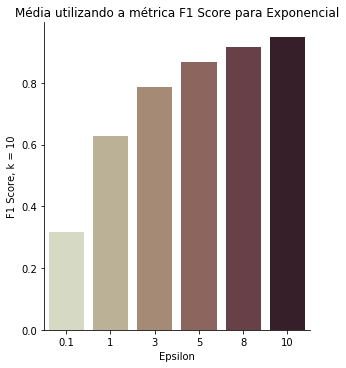

In [836]:
metodo = 'Exponencial'
plot_erros(medias, 10, metodo)